In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

newparams = {'figure.figsize': (12, 6), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}

plt.rcParams.update(newparams)

Using variables $\xi = x/L$, $\lambda = y/L$.

The equation we want to solve is 

$\nabla^2 V = 0$,

with boundary conditions 

$V(x=0, y)=0$,

$V(x=L, y)=0$,

$V(x, y=0)=0$,

$V(x, y=L)=V_0(x)$.

This results in solutions of the form 

$V(\xi, \lambda) = \sum_{n=1}^{\infty} A_n \sinh(n \pi \lambda) \sin(n \pi \xi)$,

where 

$A_n = \frac{2}{\sinh(n \pi)} \int_0^1 V_0(\xi/L) \sin(n \pi \xi) d\xi$.

In [77]:
class Potential:
    def __init__(self, N: int):
        self.coefficients_array: np.ndarray = np.zeros(N)
        self.N: int = N
        self.V: Callable[[float, float], float] = np.vectorize(self.scalar_V)
    
    def scalar_V(self, xi: float, lambd: float) -> float:
        return np.sum(self.coefficients_array * np.sinh([n*np.pi*lambd for n in range(1, self.N+1)]) * np.sin([n*np.pi*xi for n in range(1, self.N+1)]))

    def calculateCoefficients(self, V0: Callable[[float], float], M: int) -> None:
        xi_array: np.ndarray = np.linspace(0, 1, M)
        V0_array: np.ndarray = V0(xi_array)
        a_next: float = 0 
        for n in range(1, self.N+1):
            sin_array: np.ndarray = np.sin(n*np.pi*xi_array)
            a_next = np.sum(2/np.sinh(n*np.pi) * sin_array * V0_array/M)
            self.coefficients_array[n-1] = a_next


In [118]:
M: int = 500
N: int = 100

xi_array: np.ndarray = np.linspace(0, 1, M)
lambd_array: np.ndarray = np.linspace(0, 1, M)

xx, yy = np.meshgrid(xi_array, lambd_array)

def V1(xi: float) -> float:
    return 1 - (xi - 0.5)**4

P1: Potential = Potential(N)
P1.calculateCoefficients(V1, M)

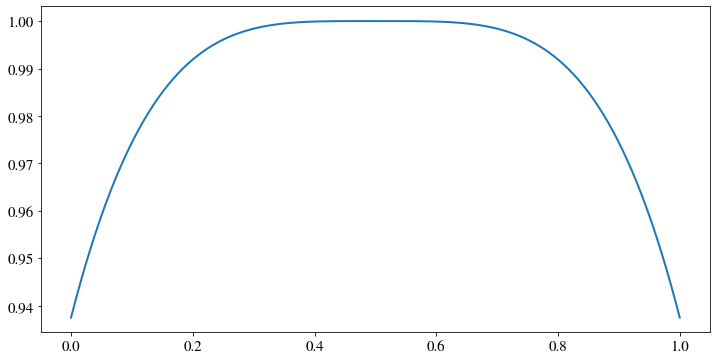

In [115]:
plt.plot(xi_array, V1(xi_array))

In [120]:
V_matrix = P1.V(xx, yy)

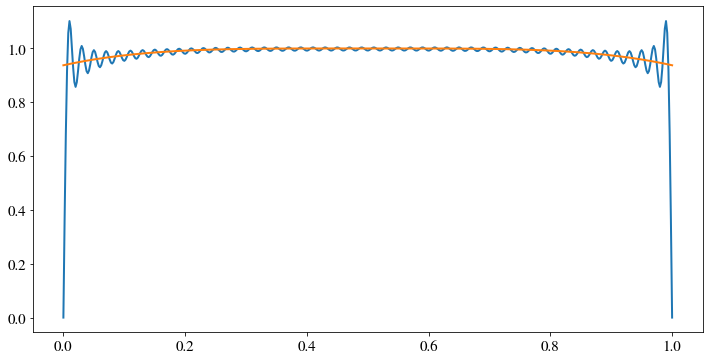

In [121]:
plt.plot(xi_array, V_matrix[-1, :])
plt.plot(xi_array, V1(xi_array))

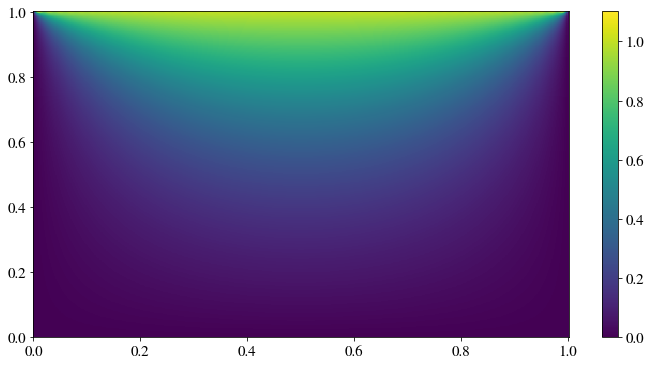

In [102]:
plt.pcolormesh(xx, yy, V_matrix)
plt.colorbar()
plt.show()

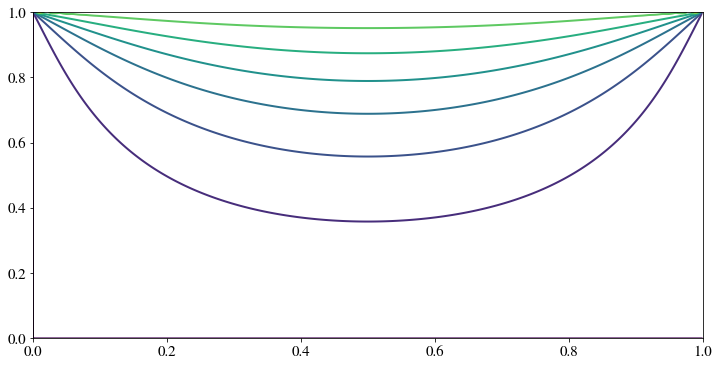

In [130]:
plt.contour(xx, yy, V_matrix)
plt.show()